In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [2]:
mnist_mean = 0.1307
mnist_std = 0.3081

In [3]:
# Getting the dataset
transforms_ori = transforms.Compose([transforms.ToTensor(), 
                                 transforms.Normalize((mnist_mean,), (mnist_std,))])
train_set = datasets.MNIST(root='./data', 
                           train=True, 
                           transform=transforms_ori, 
                           download=True)

test_set = datasets.MNIST(root='./data', 
                         train=False, 
                         transform=transforms_ori, download=True)

In [4]:
# Splitting the datasets into batches
batch_size = 100

train_loader = torch.utils.data.DataLoader(dataset=train_set, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                          batch_size=batch_size,
                                          shuffle=False)

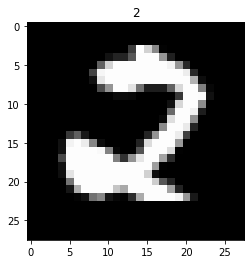

In [5]:
# Visualizing random image from dataset
index = np.random.randint(len(train_set))
img = train_set[index][0] * mnist_std + mnist_mean
plt.imshow(img.view(28, 28), cmap='gray')
plt.title(train_set[index][1])
plt.show()

![A cnn architecture for MNIST dataset](https://camo.githubusercontent.com/0901afe897bc7e3793c8584d75b1007fb0abe49a6c933a98c62594ad814d5164/68747470733a2f2f757365722d696d616765732e67697468756275736572636f6e74656e742e636f6d2f33303636313539372f36313731333437312d33633935376430302d616438622d313165392d396133382d6533663464316537323536352e706e67)

In [6]:
# Defining the cnn
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1) # out = 8*28*28
        self.batchnorm1 = nn.BatchNorm2d(num_features=8)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2) # out = 8*14*14
        
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=5, stride=1, padding=2) # out = 32*14*14
        self.batchnorm2 = nn.BatchNorm2d(num_features=32)
        # relu
        # maxpool # out = 32*7*7
        
        # Flatten # out = 32*7*7 = 1568
        self.fc1 = nn.Linear(in_features=1568, out_features=600)
        # relu
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(in_features=600, out_features=10)
        
    def forward(self, X):
        output = self.conv1(X)
        output = self.batchnorm1(output)
        output = self.relu(output)
        output = self.maxpool(output)
        
        output = self.conv2(output)
        output = self.batchnorm2(output)
        output = self.relu(output)
        output = self.maxpool(output)
        
        output = output.view(-1, 1568) # flatten. Batch_size is inferred by -1
        output = self.fc1(output)
        output = self.relu(output)
        output = self.dropout(output)
        output = self.fc2(output)
        
        return output
        

In [7]:
# Building the cnn
model = Net()

# loss_fn
loss_fn = nn.CrossEntropyLoss(reduction='mean')

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [8]:
# Training the network
num_epochs = 5
train_accuracy = []
train_loss = []
test_accuracy = []
test_loss = []

for epoch in range(num_epochs):
    # training
    correct_image = 0
    total_loss = 0
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        correct_image += (predictions == labels).sum().item()
        
        loss = loss_fn(outputs, labels)
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    accuracy = correct_image / len(train_set)
    train_accuracy.append(accuracy)
    train_loss.append(total_loss/batch_size)
    
    # testing
    correct_image = 0
    total_loss = 0
    model.eval()
    for i, (images, labels) in enumerate(test_loader):
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        correct_image += (predictions == labels).sum().item()
        
        loss = loss_fn(outputs, labels)
        total_loss += loss.item()
    accuracy = correct_image / len(test_set)
    test_accuracy.append(accuracy)
    test_loss.append(total_loss/batch_size)
    
    # Printing statistics
    print(f"Epoch: {epoch+1}/{num_epochs}, Train loss: {train_loss[-1]:.2f}, Train accuracy: {train_accuracy[-1]*100.0:.2f}% | \
Test loss: {test_loss[-1]:.2f}, Test accuracy: {test_accuracy[-1]*100.0:.2f}%")
        

Epoch: 1/5, Train loss: 3.38, Train accuracy: 83.99% | Test loss: 0.06, Test accuracy: 98.06%
Epoch: 2/5, Train loss: 1.03, Train accuracy: 94.59% | Test loss: 0.05, Test accuracy: 98.50%


KeyboardInterrupt: 

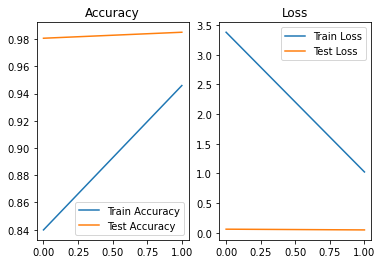

In [9]:
# Visualizing the loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(train_accuracy, label='Train Accuracy')
ax1.plot(test_accuracy, label='Test Accuracy')
ax1.set_title('Accuracy')
ax1.legend()

ax2.plot(train_loss, label='Train Loss')
ax2.plot(test_loss, label='Test Loss')
ax2.set_title('Loss')
ax2.legend()

plt.show()

In [10]:
mnist_mean = 0.1307
mnist_std = 0.3081
capture_transforms = transforms.Compose([transforms.ToPILImage(),
                                         transforms.Resize((28, 28)),
                                         transforms.ToTensor(),
                                         transforms.Normalize((mnist_mean,), (mnist_std,))])

In [25]:
# New image prediction
import cv2

image_gray = cv2.imread('./handwritten_test/digit_3.png', 0)
_, thresholded = cv2.threshold(image_gray, 200, 255, cv2.THRESH_BINARY)
image_mnist_format = 255 - thresholded

image = capture_transforms(image_mnist_format)
image = image.view(1, 1, 28, 28) # Adding batch size of 1
output = model(image)
_, prediction = torch.max(output, 1)

white_patch = np.ones((50, image_gray.shape[1]))
cv2.rectangle(white_patch, (0, 0), (160, 40), (255, 255, 255), -1)
cv2.putText(white_patch, 'Prediction: ' + str(prediction.item()), (2, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)
cv2.imshow('frame', np.concatenate((image_gray, white_patch), axis=0))
while True:
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
cv2.destroyAllWindows()

In [ ]:
# video capture prediction
import cv2
import time

cam = cv2.VideoCapture(0)
while True:
    ret, frame = cam.read()
    
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    _, thresholded = cv2.threshold(frame_gray, 127, 255, cv2.THRESH_BINARY)
    image_mnist_format = 255 - thresholded
    
    image = capture_transforms(image_mnist_format)
    image = image.view(1, 1, 28, 28) # Adding batch size of 1
    output = model(image)
    _, prediction = torch.max(output, 1)
    
    cv2.rectangle(frame, (0, 0), (160, 40), (255, 255, 255), -1)
    cv2.putText(frame, 'Prediction: ' + str(prediction.item()), (5, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)
    cv2.imshow('frame', frame)
    cv2.imshow('gray', image_mnist_format)
    
    time.sleep(0.2)
    
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cam.release()
cv2.destroyAllWindows()